# Using K_means algorithm to recognise color in image

In this Jupyter notebook, we will develop a program that identifies the dominant color in an image using the K-means clustering algorithm. The program will load an image in JPG format, process it, and apply the K-means algorithm to find the dominant color. 

The dominant color is determined by reshaping the image data into a form that the K-means algorithm can process, and then fitting the algorithm to this data. The K-means algorithm groups similar data points together, and in this case, it groups similar color values together. The color of the largest group is considered the dominant color of the image.

After identifying the dominant color, the program will visualize this color for verification. Finally, the dominant color will be exported to a text file for future reference or use.

This program is a practical application of machine learning in the field of image processing and can be useful in various domains, such as digital art, computer vision, and content creation.

## Import libraries

Necessary libraries. They are :
- `sklearn` for KMeans algorithm, 
- `matplotlib.pyplot` for plotting graphs, 
- `numpy` to work with arrays, 
- `cv2` to work with image data, 
- `collections` to use Counter to count values, 
- `rgb2lab` to convert RGB values and 
- `deltaE_cie76` to calculate similarity between colors.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

## Load the image 

Import one image in jpg form

The type of this input is <class 'numpy.ndarray'>
Shape: (100, 100, 3)


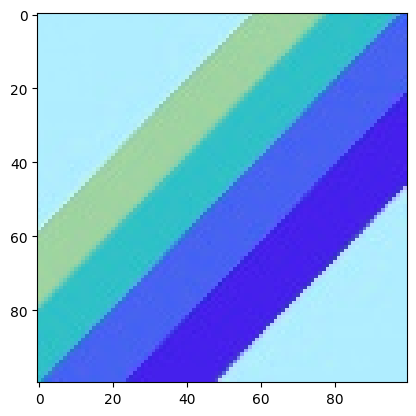

In [2]:
image = cv2.imread('images_jpg\\colors.jpg')
if image is None:
    print("Failed to load image")
else:
    print("The type of this input is {}".format(type(image)))
    print("Shape: {}".format(image.shape))
    plt.imshow(image)

### Note
The image appears to have altered colors when compared to the original. This discrepancy arises because OpenCV, by default, processes images in the BLUE GREEN RED (BGR) color sequence. Therefore, we need to adjust this to the RED GREEN BLUE (RGB) sequence to maintain the original color representation.

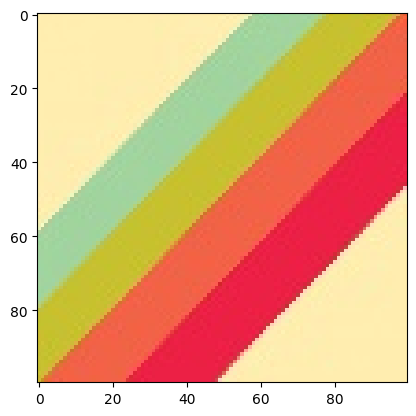

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Note
In cases where we are dealing with large images or multiple images of varying dimensions, it may be beneficial to resize the images to a consistent size.

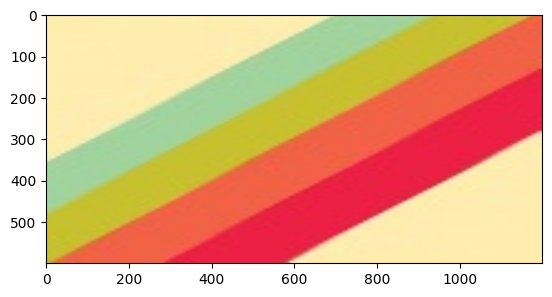

In [4]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

## Color Identification (1 primary color)

I use this function in order to take the `hex` values of the colors that I will identify.

In [5]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def load_image(image_path) : reads an image from the provided path and converts it from BGR -> RGB color space

In [6]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Note
I will plot the data points in 3D space using python matplotlib in order to see the pixels how they are in the space

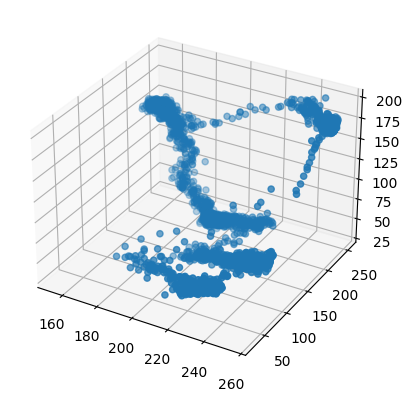

In [7]:
%matplotlib inline

#get rgb values from image to 1D array
r, g, b = cv2.split(image)
r = r.flatten()
g = g.flatten()
b = b.flatten()

#plotting 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b)
plt.show()

extract_colors(image, number_of_colors, show_chart): does the main work of color extraction.

In [8]:
def extract_colors(image, number_of_colors, show_chart):
    
    # resize the image to speed up processing time
    #interpolation is a metod to reduce the size of the image while keeping the quality good
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    # change the shape of the image, before it was 3D array(height, width, color channels), now it is 2D array(number of pixels, color channels)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    # create the model
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel
    # more specifcally, if we have 3 clusters, the labels will be 0, 1, 2, and each pixel will be assigned to one of these clusters, so if a particular pixel has label 0, it means it belongs to the first cluster
    
    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort to ensure correct color percentage
    
    # get the cluster centers
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    # show the chart
    if (show_chart):
        plt.figure(figsize = (8, 6)) # set the size of the chart
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors) # create the pie chart
    
    return rgb_colors ,labels

### Call the function with the number of dominant colors that you want to appeared

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([array([253.92475884, 236.70418006, 175.82797428]),
  array([240.21839646,  99.09837678,  69.86866699]),
  array([163.52706553, 210.8974359 , 154.95156695]),
  array([199.96876712, 191.1709589 ,  50.83342466]),
  array([233.23280098,  33.57739558,  67.39189189])],
 array([0, 0, 0, ..., 0, 0, 0]))

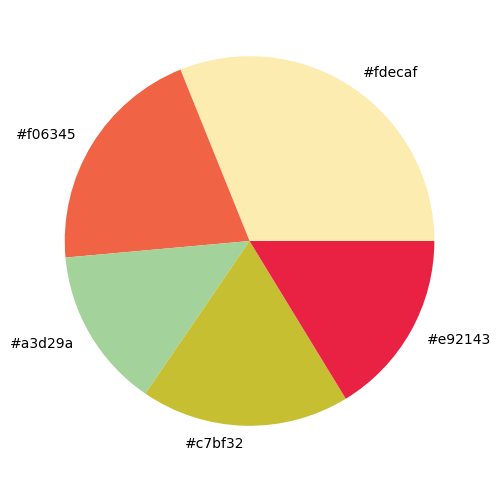

In [9]:
extract_colors(load_image('images_jpg\\colors.jpg'), 5, True)

### New Plot with the Colors

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


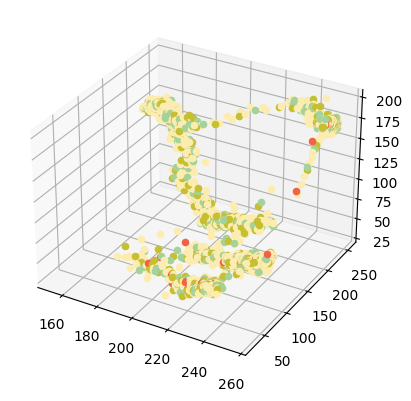

In [28]:
def visualize_clusters(image, labels, colors):
    r, g, b = cv2.split(image)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for label, pix in zip(labels, zip(r, g, b)):
        ax.scatter(pix[0], pix[1], pix[2], color = RGB2HEX(colors[label]))
    plt.show()

rgb_colors, labels = extract_colors(image, number_of_colors=5, show_chart=False)
visualize_clusters(image, labels, rgb_colors)

### Show which color is most effective 
it means which clusters has the most data points 

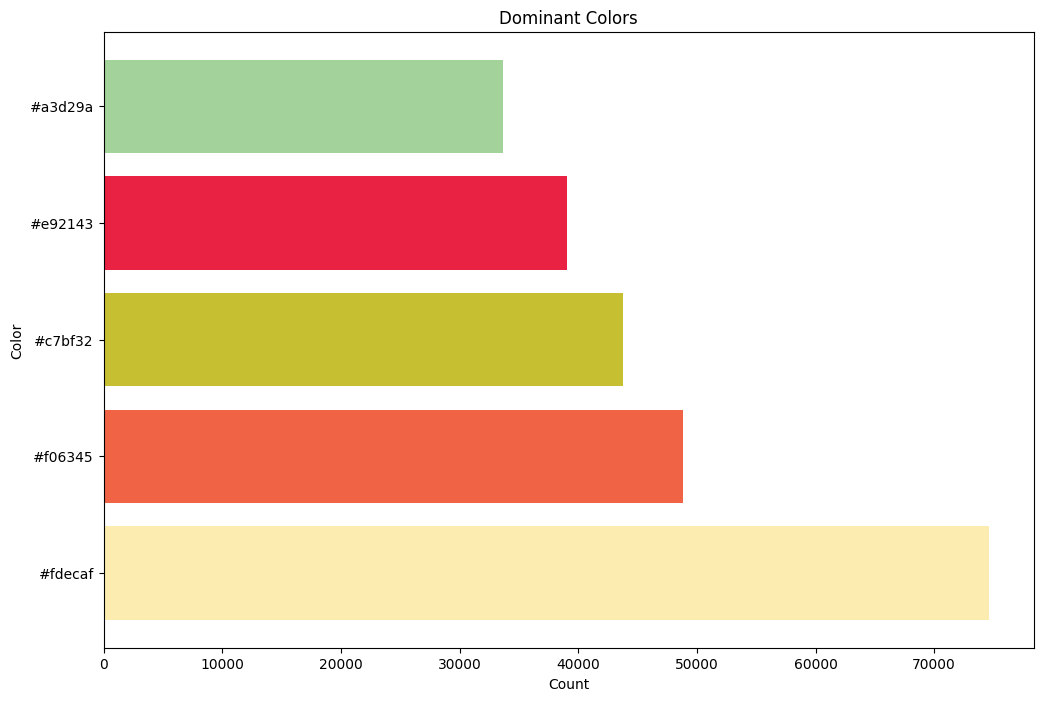

In [32]:
def display_dominant_colors(counts, hex_colors):
    # sort the counts dictionary in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # create lists for colors and their counts
    dominant_colors = [hex_colors[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    # create a bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(dominant_colors, counts, color=dominant_colors)
    plt.xlabel('Count')
    plt.ylabel('Color')
    plt.title('Dominant Colors')
    plt.show()
    
# Count labels
counts = Counter(labels)

# Convert RGB colors to HEX
hex_colors = [RGB2HEX(rgb_color) for rgb_color in rgb_colors]

# Display dominant colors
display_dominant_colors(counts, hex_colors)

### Metrics 
We use them to evaluate the quality and performance of the algorithm . Below are some of the metrics :

#### 

## Conclusion

In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.